In [1]:
!pip install transformers -q

     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 6.6 MB 45.1 MB/s 
     |████████████████████████████████| 596 kB 51.4 MB/s 


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from numpy import array, concatenate, unique
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from sklearn.utils import class_weight
from pandas import read_csv, DataFrame
import torch.nn.functional as F
from argparse import Namespace
from torch.optim import AdamW
from os.path import join
from tqdm import tqdm
from torch import nn
import numpy as np
import random
import torch
from torch.utils.data import (TensorDataset,
                              DataLoader,
                              RandomSampler,)

In [3]:
def get_params() -> dict:
    """
    Direcciones y nombres de los archivos donde estan contenidos 
    los datos que se usaran para el entrenamiento, validacion y test
    """
    params = {
        "root": "/content/drive/MyDrive/Lenguaje/Tarea_07",
        "path data": "Data",
        "path results": "Results",
        "train file": "train.csv",
        "val file": "val.csv",
        "test file": "test.csv",
    }
    params["path data"] = join(params["root"],
                               params["path data"])
    params["path results"] = join(params["root"],
                               params["path results"])
    params["train file"] = join(params["path data"],
                                params["train file"])
    params["val file"] = join(params["path data"],
                              params["val file"])
    params["test file"] = join(params["path data"],
                               params["test file"])
    return params

def get_args() -> Namespace:
    """
    Argumentos utilizados para el tokenizador y el proceso de entrenamiento
    de la red neuronal
    """
    args = Namespace()
    args.max_tokens = 130
    args.batch_size = 8
    args.epoch = 3
    args.lr = 1e-5
    args.device = torch.device('cuda')
    return args

def tokenize_data(data: list, tokenizer, args: Namespace) -> dict:
    """
    Realiza el proceso de tokenizacion de una lista de datos
    """
    token_list = tokenizer.batch_encode_plus(
        data,
        max_length=args.max_tokens,
        pad_to_max_length=True,
        add_special_tokens=True,
        truncation='longest_first')
    return token_list


def get_seq_and_mask(tokens_data: dict, data: DataFrame = None) -> tuple:
    """
    Obtiene los tensores correspondientes a los datos introducidos.
    Si no se introduce un dataframe en la ultima capa esto indica que
    no existen los valores de target del dataset dado
    """
    seq = torch.tensor(tokens_data['input_ids'])
    mask = torch.tensor(tokens_data['attention_mask'])
    if data is not None:
        y = torch.tensor(list(map(int,
                                  data["target"].to_numpy())))
        return seq, mask, y
    return seq, mask


def get_weights(data: DataFrame, target: list, args: Namespace) -> array:
    """
    Obtiene los pesos para realizar un balance en las categorias de los datos 
    """
    # Pesos de cada clase
    weights_class = class_weight.compute_class_weight('balanced',
                                           classes=unique(target),
                                           y=data["target"].to_list())
    # Conversion a tensor
    weights = torch.tensor(weights_class,
                           dtype=torch.float)
    # LLevado hacia la GPU
    weights = weights.to(args.device)
    return weights


def create_dataloader(seq: array, mask: array, target: array = None) -> tuple:
    """
    Crea los dataloaders de cada secuencia de datos
    """
    if target is not None:
        # Concatenacion de los datos en un solo tensor
        data = TensorDataset(seq,
                             mask,
                             target)
        # Muestras del tensor
        sampler = RandomSampler(data)
        # Creacion del dataloader en base a muestras
        dataloader = DataLoader(data,
                                sampler=sampler,
                                batch_size=args.batch_size)
        return dataloader
    
    # Espacio para la creacion del dataloader para los datos de test 
    data = TensorDataset(seq,
                         mask)
    dataloader = DataLoader(data,
                            batch_size=args.batch_size)
    return dataloader

In [4]:
class RobertuitoClasificator(nn.Module):
    """
    Creacion del modelo de Robertuito
    """
    def __init__(self, transformer):
        super(RobertuitoClasificator, self).__init__()
        # pretrained
        self.transformer = transformer

    def forward(self, sent_id, mask):
        # Get cls token
        x = self.transformer(sent_id,
                             attention_mask=mask,
                             return_dict=False)[0]
        return x

In [5]:
class robertito_model:
    """
    Aglomeracion de los procesos de entrenamiento, validacion y test del modelo
    de robertito
    """
    def __init__(self, params: dict, args: Namespace, weights: array) -> None:
        self.params = params
        self.args = args
        self._create_model(weights)

    def _create_model(self, weights: array) -> None:
        """
        Definicion del modelo, optimizador y funcion de costo
        """
        robertuito = AutoModelForSequenceClassification.from_pretrained(
            "pysentimiento/robertuito-base-uncased")
        robertuito = robertuito.to(self.args.device)
        # Creacion del modelo
        self.model = RobertuitoClasificator(robertuito)
        # Llevado al GPU
        self.model = self.model.to(self.args.device)
        # Optimizador
        self.optimizer = AdamW(self.model.parameters(),
                               lr=self.args.lr)
        # Funcion de costo
        self.cross_entropy = nn.CrossEntropyLoss(weight=weights)

    def _train(self, train_dataloader):
        """
        Entrenamieto del 
        """
        self.model.train()
        # Inicializacion de las variables
        total_loss = 0
        acc = 0
        predictions = []
        targets = []
        for step, batch in tqdm(enumerate(train_dataloader),
                                desc="Training",
                                total=len(train_dataloader)):
            # Datos hacia la GPU
            batch = [r.to(self.args.device)
                     for r in batch]
            sent_id, mask, labels = batch
            # Limpieza de procesos anteriores
            self.model.zero_grad()
            # Prediccion
            preds = self.model(sent_id,
                               mask)
            lab = F.log_softmax(preds,
                                  dim=1)
            # Funcion de costo
            loss = self.cross_entropy(lab,
                                      labels)
            total_loss = total_loss + loss.item()
            loss.backward()
            # Maximo de 1 para que no explote
            torch.nn.utils.clip_grad_norm_(self.model.parameters(),
                                           1.0)
            # Actualizacion de los parametrod
            self.optimizer.step()
            # Predicciones a cpu
            preds = preds.detach().cpu().numpy()
            # Guardado de las preducciones
            predictions += lab.argmax(1).cpu().tolist()
            targets += labels.cpu().tolist()
        # Accuracy
        acc = accuracy_score(targets,
                             predictions)
        avg_loss = total_loss / len(train_dataloader)
        return avg_loss, acc

    def _evaluate(self, val_dataloader):
        """
        Evaluacion del modelo
        """
        # Desactivacion del entrenamiento
        self.model.eval()
        # Inicializacion de las variables
        total_loss = 0
        total_preds = []
        targets = []
        predictions = []
        for step, batch in tqdm(enumerate(val_dataloader),
                                desc="Validation",
                                total=len(val_dataloader)):
            # Llevado hacia la GPU
            batch = [t.to(self.args.device)
                     for t in batch]
            sent_id, mask, labels = batch
            # No toma en cuenta el gradiente
            with torch.no_grad():
                # Predicciones
                preds = self.model(sent_id,
                                   mask)
                lab = F.log_softmax(preds,
                                    dim=1).argmax(1)
                # Funcion de costo
                loss = self.cross_entropy(preds,
                                          labels)
                total_loss = total_loss + loss.item()
                preds = preds.detach().cpu().numpy()
                total_preds.append(preds)
            predictions += lab.cpu().tolist()
            targets += labels.cpu().tolist()
        acc = accuracy_score(targets,
                             predictions)
        # Funcion de costo promedio
        avg_loss = total_loss / len(val_dataloader)
        return avg_loss, acc

    def run(self, train_dataloader, val_dataloader) -> None:
        """
        Ejecuccion del entrenamiento del modelo y su validacion
        """
        self.train = dict(loss=[],
                          acc=[])
        self.val = dict(loss=[],
                        acc=[]) 
        for epoch in range(self.args.epoch):
            print("="*30)
            print(f"Epoch {epoch+1}")
            # Entrenamiento dle modelo
            train_loss, train_acc = self._train(train_dataloader)
            self.train["loss"]+=[train_loss]
            self.train["acc"]+=[train_acc]
            # Evaluacion del modelo
            val_loss, val_acc = self._evaluate(val_dataloader)
            self.val["loss"]+=[val_loss]
            self.val["acc"]+=[val_acc]
            # Guardado de cada modelo en cada epoca
            torch.save(self.model.state_dict(),
                       f'saved_weights{epoch}.pt')
            print('Training Loss:   {:.4f}\t Training accuracy:  {:.4f}'.format(train_loss,
                                                                            train_acc))
            print('Validation Loss: {:.4f}\t Validation accuracy {:.4f}'.format(val_loss,
                                                                                val_acc))

    def load(self, path: str) -> None:
        """
        Lectura de algun estado del modelo
        """
        self.model.load_state_dict(torch.load(path))
        self.model.eval()

    def predict(self, test_dataloader):
        """
        Prediccion dado un dataloader
        """
        predictions = []
        for batch in test_dataloader:
            sent_id, masks = batch
            sent_id = sent_id.to(self.args.device)
            # LLevado hacia la GPU
            masks = masks.to(self.args.device)
            # Predicciones
            output = self.model(sent_id,
                                masks)
            # Probabilidad
            preds = F.softmax(output,
                              dim=1).argmax(1)
            # Guardado de las predicciones
            predictions += preds.tolist()
        # LLevado a un dataframe
        predictions = DataFrame(predictions,
                                columns=["Expected"])
        predictions.index.name = "Id"
        return predictions

In [6]:
params = get_params()
set_seeds()
args = get_args()
tokenizer = AutoTokenizer.from_pretrained(
    "pysentimiento/robertuito-base-uncased")

train_data = read_csv(params["train file"])
val_data = read_csv(params["val file"])
test_data = read_csv(params["test file"])

Downloading:   0%|          | 0.00/323 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/838k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [7]:
tokens_train = tokenize_data(train_data["text"].to_list(),
                             tokenizer,
                             args)
tokens_val = tokenize_data(val_data["text"].to_list(),
                           tokenizer,
                           args)
tokens_test = tokenize_data(test_data["text"].to_list(),
                            tokenizer,
                            args)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [8]:
train_seq, train_mask, y_train = get_seq_and_mask(tokens_train,
                                                  train_data)
val_seq, val_mask, y_val = get_seq_and_mask(tokens_val,
                                            val_data)
test_seq, test_mask = get_seq_and_mask(tokens_test)

weights = get_weights(train_data,
                      y_train,
                      args)

In [9]:
# dataLoader for train set
train_dataloader = create_dataloader(train_seq,
                                     train_mask,
                                     y_train)
val_dataloader = create_dataloader(val_seq,
                                   val_mask,
                                   y_val)
test_dataloader = create_dataloader(test_seq,
                                    test_mask)

In [ ]:
robertuito = robertito_model(params,
                             args,
                             weights)
robertuito.run(train_dataloader,
               val_dataloader)

Some weights of the model checkpoint at pysentimiento/robertuito-base-uncased were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-base-uncased and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.

Epoch 1


Validation: 100%|██████████| 74/74 [00:02<00:00, 28.43it/s]


Training Loss:   0.4185	 Training accuracy:  0.8295
Validation Loss: 0.3004	 Validation accuracy 0.8893
Epoch 2


Validation: 100%|██████████| 74/74 [00:02<00:00, 28.57it/s]


Training Loss:   0.2611	 Training accuracy:  0.9248
Validation Loss: 0.4029	 Validation accuracy 0.8910
Epoch 3


Validation: 100%|██████████| 74/74 [00:02<00:00, 28.56it/s]


Training Loss:   0.1533	 Training accuracy:  0.9610
Validation Loss: 0.4962	 Validation accuracy 0.9046


In [ ]:
results=robertuito.predict(test_dataloader)

In [ ]:
filename = "results.csv"
results.to_csv(filename)

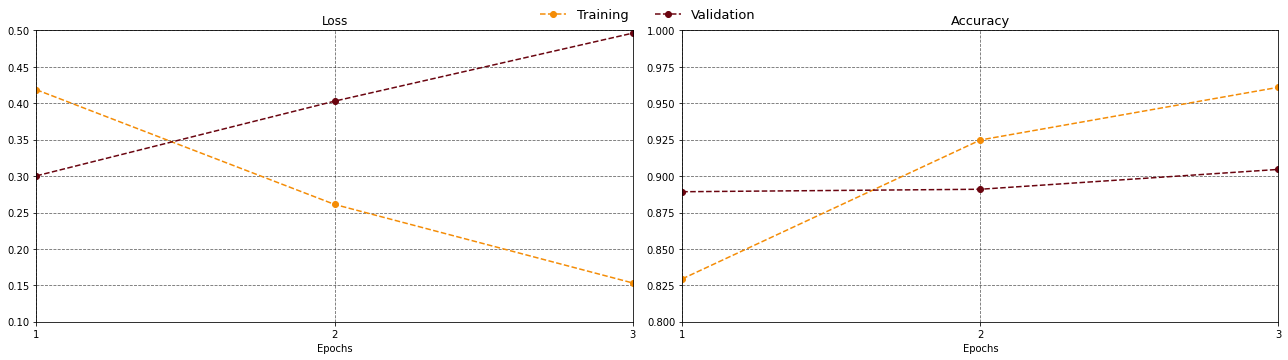

In [ ]:
import matplotlib.pyplot as plt
from numpy import linspace
fig,(ax1,ax2)=plt.subplots(1,2,
                           figsize=(18,5),
                           sharex=True)
x = range(1,4)
ax1.set_xlim(1,3)
ax1.set_xticks(x)
ax1.plot(x,
         robertuito.train["loss"],
         label="Training",
         ls="--",
         marker="o",
         color="#f48c06")
ax1.plot(x,
         robertuito.val["loss"],
         label="Validation",
          ls="--",
         marker="o",
         color="#6a040f")
ax1.grid(ls="--",
         color="#000000",
         alpha=0.6)
ax1.set_ylim(0.1,0.5)
ax1.set_yticks(linspace(0.1,0.5,9))
ax1.set_title("Loss")
ax1.set_xlabel("Epochs")
ax2.plot(x,
         robertuito.train["acc"],
          ls="--",
         marker="o",
         color="#f48c06")
ax2.plot(x,
         robertuito.val["acc"],
         ls="--",
         marker="o",
         color="#6a040f")
ax2.grid(ls="--",
         color="#000000",
         alpha=0.6)
ax2.set_title("Accuracy",
              fontsize=13)
ax2.set_ylim(0.8,1)
ax2.set_xlabel("Epochs")
fig.legend(frameon=False,
           ncol=2,
           fontsize=13,
           loc="upper center",
           bbox_to_anchor=(0.5,1.01))
plt.tight_layout()
plt.savefig("history.png",
            dpi=400)